# Objective

- Implement a custom ReAct agent by overriding `langchain` abstractions


# Setup

## Installation

In [1]:
! pip install -q openai==1.55.3 \
                 langchain==0.3.7 \
                 langchain-openai==0.2.9 \
                 langchain-community==0.3.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00


In [2]:
!pip install pydantic==2.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.27.2
    Uninstalling pydantic_core-2.27.2:
      Successfully uninstalled pydantic_core-2.27.2
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.6
    Uninstalling pydantic-2.10.6:
      Successfully uninstalled pydantic-2.10.6


## Imports

In [3]:
import json

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent

from langchain_openai import AzureChatOpenAI

In [ ]:
# with open('config-azure.json') as f:
#     configs = f.read()

In [ ]:
# creds = json.loads(configs)

In [ ]:
# llm = AzureChatOpenAI(
#     azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
#     api_key=creds["AZURE_OPENAI_KEY"],
#     api_version="2024-02-01",
#     model="gpt-4o", # Notice the model
#     temperature=0.2
# )

In [7]:
from google.colab import userdata
azure_api_key = userdata.get('azure_api_key')

In [8]:
llm = AzureChatOpenAI(
    azure_endpoint="https://azure-openai-lab-001.openai.azure.com/",
    api_key=azure_api_key,
    api_version="2024-05-01-preview",
    model="gpt-4o",
    temperature=0
)

# Business Objective

Consider a credit card company that wants to build an internal agent that hooks up to the company database to answer questions asked by analysts in natural language. The internal database comprises several tables and is represented with the schema below.

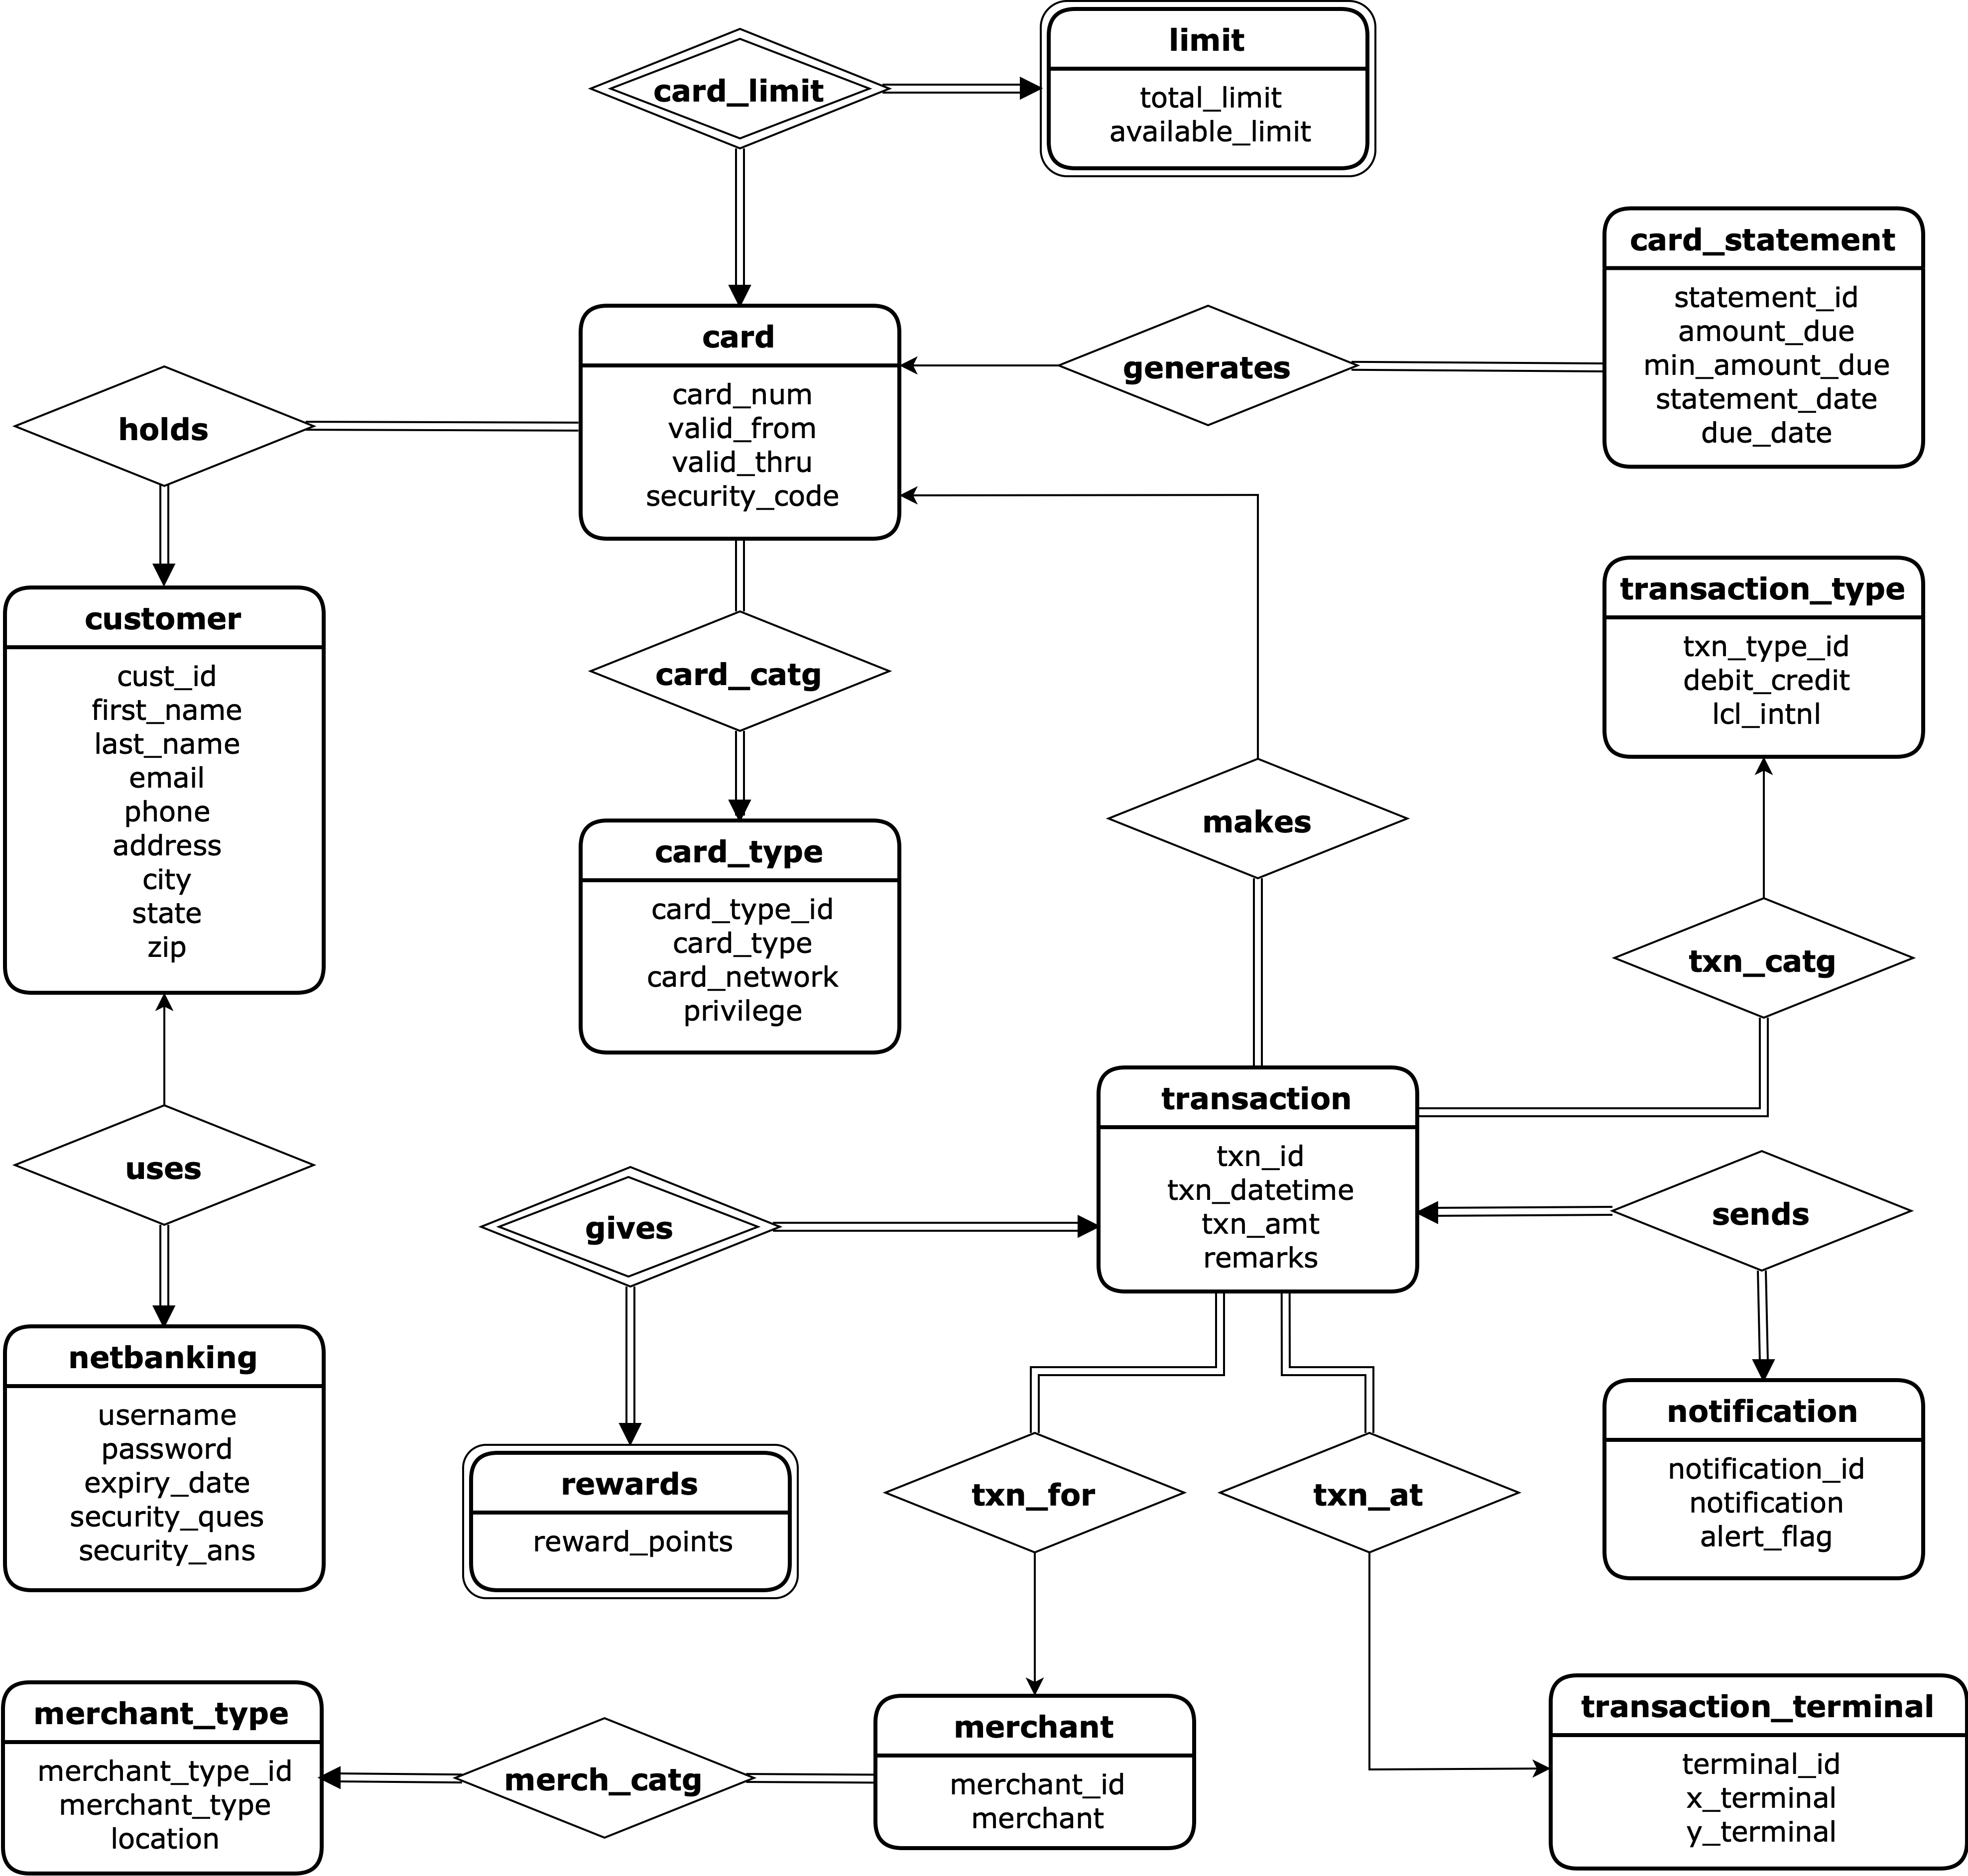

# Solution Implementation

While we implemented an SQL Agent using LangChain abstractions without modification, the implementation is too general and leaves several optimization on the table. One specific optimization that can be implemented to reduce the tokens burnt during execution is to override the system message. The key issue with the default LangChain SQL agent is that it is not aware of the schema and has to always list the tables before each query. This is wasteful since it increases both the token count and latency.

In this notebook we amend the system message infusing the above database schema that the agent has access to hence cutting the planning process and the accuracy of the outputs.

In [10]:
creditcard_db = SQLDatabase.from_uri("sqlite:///ccms.db")

Now that we have a connection with the database, we can inspect its schema like so:

In [11]:
context = creditcard_db.get_context()
database_schema = context['table_info']

In [12]:
print(database_schema)


CREATE TABLE "transaction" (
	"Unnamed: 0" INTEGER, 
	"TXN_ID" TEXT, 
	"TX_DATETIME" TEXT, 
	"CARD_ID" INTEGER, 
	"TERMINAL_ID" INTEGER, 
	"TX_AMOUNT" REAL, 
	"TX_TIME_SECONDS" INTEGER, 
	"TX_TIME_DAYS" INTEGER, 
	"TXN_TYPE_ID" INTEGER, 
	"M_ID" INTEGER
)

/*
3 rows from transaction table:
Unnamed: 0	TXN_ID	TX_DATETIME	CARD_ID	TERMINAL_ID	TX_AMOUNT	TX_TIME_SECONDS	TX_TIME_DAYS	TXN_TYPE_ID	M_ID
0	202206011726142261372776857602093	2022-06-01 17:26:14	2261372776857602	93	171.96	62774	0	1	5
1	202206031902022261372776857602042	2022-06-03 19:02:02	2261372776857602	42	60.58	241322	2	2	6
2	202206041441262261372776857602083	2022-06-04 14:41:26	2261372776857602	83	104.57	312086	3	2	4
*/


CREATE TABLE card (
	card_number INTEGER, 
	valid_from TEXT, 
	expiry TEXT, 
	security_code INTEGER, 
	"x-coordinate" REAL, 
	"y-coordinate" REAL, 
	mean_amount REAL, 
	std_amount REAL, 
	mean_nb_tx_per_day REAL, 
	cust_id INTEGER, 
	card_type_id INTEGER
)

/*
3 rows from card table:
card_number	valid_from	exp

Let us now customize the system prompt of the SQL agent so that it is aware of the schema and hence does not need to waste tokens calling the list tables tool for each query.

In [13]:
system_message = f"""You are a SQLite expert agent designed to interact with a SQLite database.
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database..
You can order the results by a relevant column to return the most interesting examples in the database.
Carefully consider all the tables in the database schema and select appropriate columns in the table to compose queries (especially joins).
Query only the columns that are needed to answer the question.
Wrap each column name in double quotes (") to denote them as delimited identifiers.
You have access to tools for interacting with the database.
Only use the given tools. Only use the information returned by the tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If the question does not seem related to the database, just return "I don't know" as the answer.

Only use the following tables:
{database_schema}
"""

We can now override the full prompt used by the agent for each query like so:

In [14]:
full_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("human", '{input}'),
        MessagesPlaceholder("agent_scratchpad")
    ]
)

We can now create a new executor wrapping the same llm and with the same tools but with a sharper system message defined above like so:

In [15]:
sqlite_agent_executor = create_sql_agent(
    llm=llm,
    db=creditcard_db,
    prompt=full_prompt,
    agent_type="openai-tools",
    agent_executor_kwargs={'handle_parsing_errors':True},
    max_iterations=5,
    verbose=True
)

In [16]:
def answer(user_query, sqlite_agent_executor):

    try:
        response = sqlite_agent_executor.invoke(user_query)

        prediction = response['output']

    except Exception as e:
        prediction = e

    return prediction

In [17]:
## 1
user_query = "Who are the top 5 merchants by number of transactions executed?"
response = answer(user_query, sqlite_agent_executor)
print(response)



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_query_checker` with `{'query': 'SELECT "merchant", COUNT("transaction"."TXN_ID") AS transaction_count FROM "merchant" \nJOIN "transaction" ON "merchant"."id" = "transaction"."M_ID" \nGROUP BY "merchant"."merchant" \nORDER BY transaction_count DESC \nLIMIT 5;'}`


```sql
SELECT "merchant", COUNT("transaction"."TXN_ID") AS transaction_count 
FROM "merchant" 
JOIN "transaction" ON "merchant"."id" = "transaction"."M_ID" 
GROUP BY "merchant"."merchant" 
ORDER BY transaction_count DESC 
LIMIT 5;
```
Invoking: `sql_db_query` with `{'query': 'SELECT "merchant", COUNT("transaction"."TXN_ID") AS transaction_count FROM "merchant" \nJOIN "transaction" ON "merchant"."id" = "transaction"."M_ID" \nGROUP BY "merchant"."merchant" \nORDER BY transaction_count DESC \nLIMIT 5;'}`


[('Amazon', 22361), ('Walgreens Boots Alliance', 22267), ('Best Buy', 22256), ('Publix', 22236), ('Target Corporation', 22234)]The top 5 merchants by the number of

In [18]:
## 2
user_query = "What was the percentage contribution of spends by females for each card type?"
response = answer(user_query, sqlite_agent_executor)
print(response)



> Entering new SQL Agent Executor chain...
To calculate the percentage contribution of spends by females for each card type, we need to:

1. Identify the gender of the cardholders. However, the current schema does not have a gender column in any table. Without gender information, we cannot determine the contribution of spends by females.

Thus, I cannot answer this question with the current database schema.

> Finished chain.
To calculate the percentage contribution of spends by females for each card type, we need to:

1. Identify the gender of the cardholders. However, the current schema does not have a gender column in any table. Without gender information, we cannot determine the contribution of spends by females.

Thus, I cannot answer this question with the current database schema.
